In [ ]:
import sys
sys.path.insert(0, '..')

import os 
cwd = os.getcwd()
if 'notebooks' not in cwd :
    os.chdir('./Exo-Evol/notebooks/')

import numpy as np
import pandas as pd
from python_modules.grid_data_processing_module import load_grid
from python_modules.plotting_tools_module import IdentifyTransit, PlotTransitRetreival
from python_modules.fitting_observation_module import RetrieveTransit_MCMC, RetrieveTransit_UltraNest
from python_modules.regression_module import MLmodels
from python_modules.physics_module import T_irr_at_planet
import matplotlib.pyplot as plt

In [2]:
R_J = 69911000          # Jupiter radius in meters  
M_J = 1.898e27          # Jupiter mass in kilograms  
R_s = 696340000         # Solar radius in meters  
M_s = 1.989e30         # Solar mass in kilograms  
R_E = 6371e3           # Earth radius in meters  
M_E = 5.972e24         # Earth mass in kilograms  
G_u = 6.674e-11        # Gravitational constant (m^3 kg^-1 s^-2)  
Na = 6.022e23          # Avogadro's number (mol^-1)  
Kb = 1.380649e-23      # Boltzmann constant (J K^-1)  
R_g = 8.31446261815324 # Universal gas constant (J mol^-1 K^-1)  
sigma = 5.67e-8        # Stefan-Boltzmann constant (W m^-2 K^-4)  

# WASP-39 b Transit Spectrum Tutorial

This document is a tutorial on how to use the **HADES** codes—currently under development—to visualize and model a transit spectrum. *WASP-39 b* is used as an example. The approach follows Wilkinson et al. (2024) but with an expanded grid. The tools are still in development.

*IdentifyTransit* is a class with the function *plot\_transit*, which is used to visualize a transit spectrum to be fitted.

If a *.txt* file is present in *./data/transit\_spectra/* and has a name similar to the provided *"planet"* argument, it will be automatically detected and plotted. The file must contain three columns: **wavelength, flux, and error**, with no header required.


loaded example wavelength


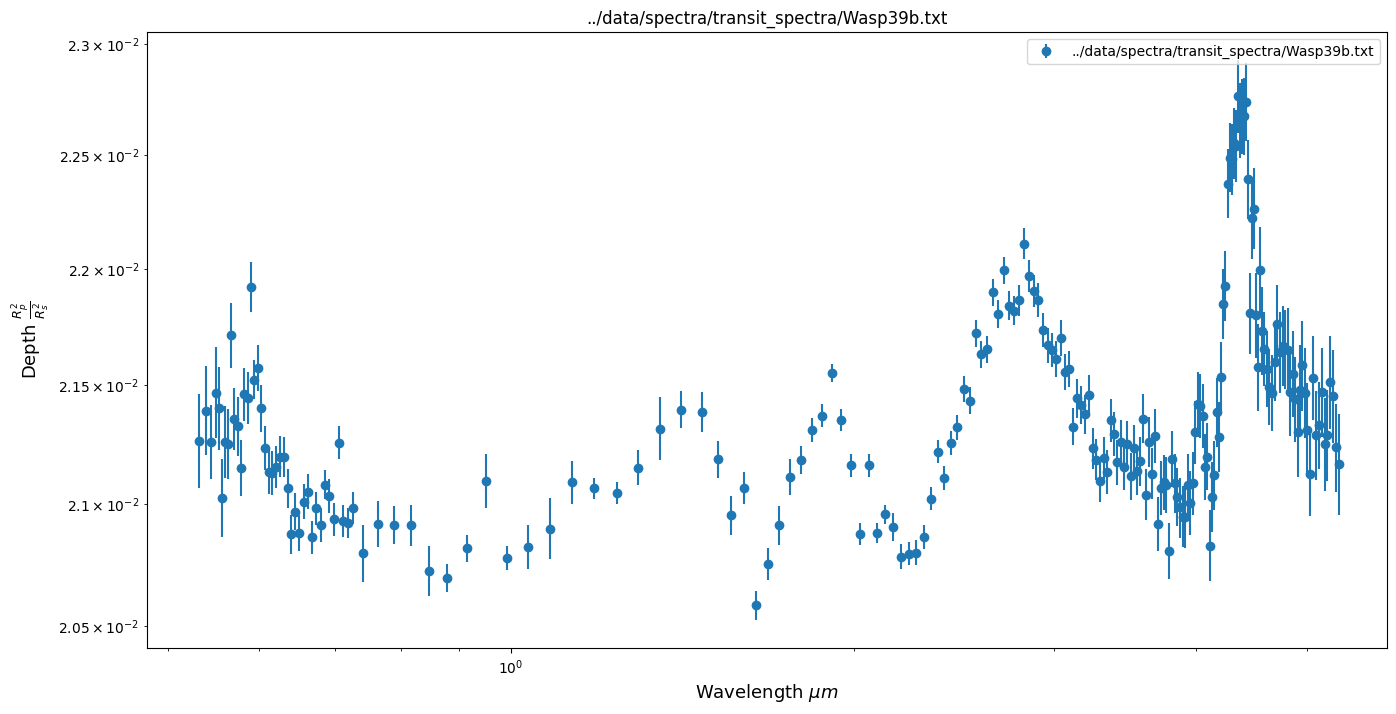

<class 'pandas.core.frame.DataFrame'>


In [ ]:
IT = IdentifyTransit(
    planet = 'wasp39b')
IT.plot_transit()

The grid of models can be found in *./data/planets/dec2024* (for the latest version). This grid is generated using the *./main/create_grid.py* script and is designed to run on a cluster.  

The input parameters for the grid are:

| Parameter | grid name | unit | approximate range |
| :-: | :-: | :-: | :-: |
| Mass | 'Mass_Jup' | Jupiter | 0.1 to 20 |
| Irradiation temperature | 'T_irr' | K | 0 to 2000 |
| Metallicity | 'Met' | dex | -1 to 1.2 |
| Core mass | 'core_Earth' | Earth | 1 to 40 |
| Intrinsic temperature | 'T_int' | K | 100 to 2000 |
| Sedimentation | 'f_sed' | - | 1 to 6 |
| Vertical motion | 'kzz' | $cm^2/s$ | 10000.0 to 1000000000000.0 |

The output parameter are as follows :

| Parameter | grid name | unit |
| :-: | :-: | :-: |
| Radius | 'Radius_Jup' | Jupiter |
| Entropy | 'S' | - |
| Emission spectrum | 'flux' | $W/m^2/\mu m$ |
| Transit spectrum | 'depth' | - |

This grid of models is not easily usable on its own; therefore, it is repackaged into a function. In Wilkinson et al. (2024), we describe the use of interpolation tools, specifically *LinearNDInterpolator* from SciPy.  

Due to the expansion of the parameter space, we now use machine learning (ML) regression tools. These are generated by *./main/create_regressors.py*, which is also designed to run on a cluster.  


We first load the machine learning class named *MLmodels*, and using the *load_model* function, we can load the transit depth ML model named *depth_lgb* (*lgb*: Light Gradient Boosted).  


In [8]:
ML = MLmodels()
ML_depth = ML.load_model('depth_radius')

loaded example wavelength
Loading ../data/interpolators/nonlinear//depth_radius.pkl
Loaded ../data/interpolators/nonlinear//depth_radius.pkl


We can define a planet using the input parameters listed above (the order must be the same) and run the model using the *use_model* function. We can then plot the output, with wavelengths stored in *ML.wavelength*.  

The depth ($R_p^2 / R_s^2$) is adjusted for the radius of the star used when running the Exo-REM module. Since the transit spectrum needs to be rescaled, this is done by multiplying by ($ML.star^2 / R_{\text{star}}^2$), where $R_{\text{star}}^2$ is the radius of the star under study (here, WASP-39 b, approximately $0.9 \times R_{\odot}$).  


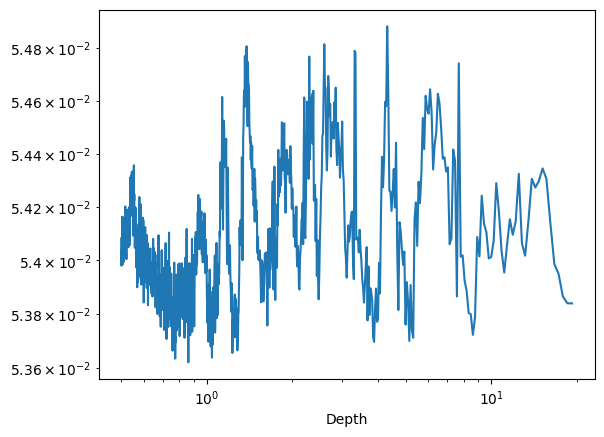

In [9]:
planet = np.array([0.28,1100,1,20,1000,3,1e6]).reshape(1,-1)
model_depth = ML.use_model(ML_depth,planet).reshape(-1,1)[:-1]
radius = ML.use_model(ML_depth,planet).reshape(-1,1)[-1]
model_depth = model_depth*radius**2/(0.9*R_s)**2

plt.figure()
plt.plot(ML.wavelength,model_depth)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.xlabel(r'Depth')
plt.show()

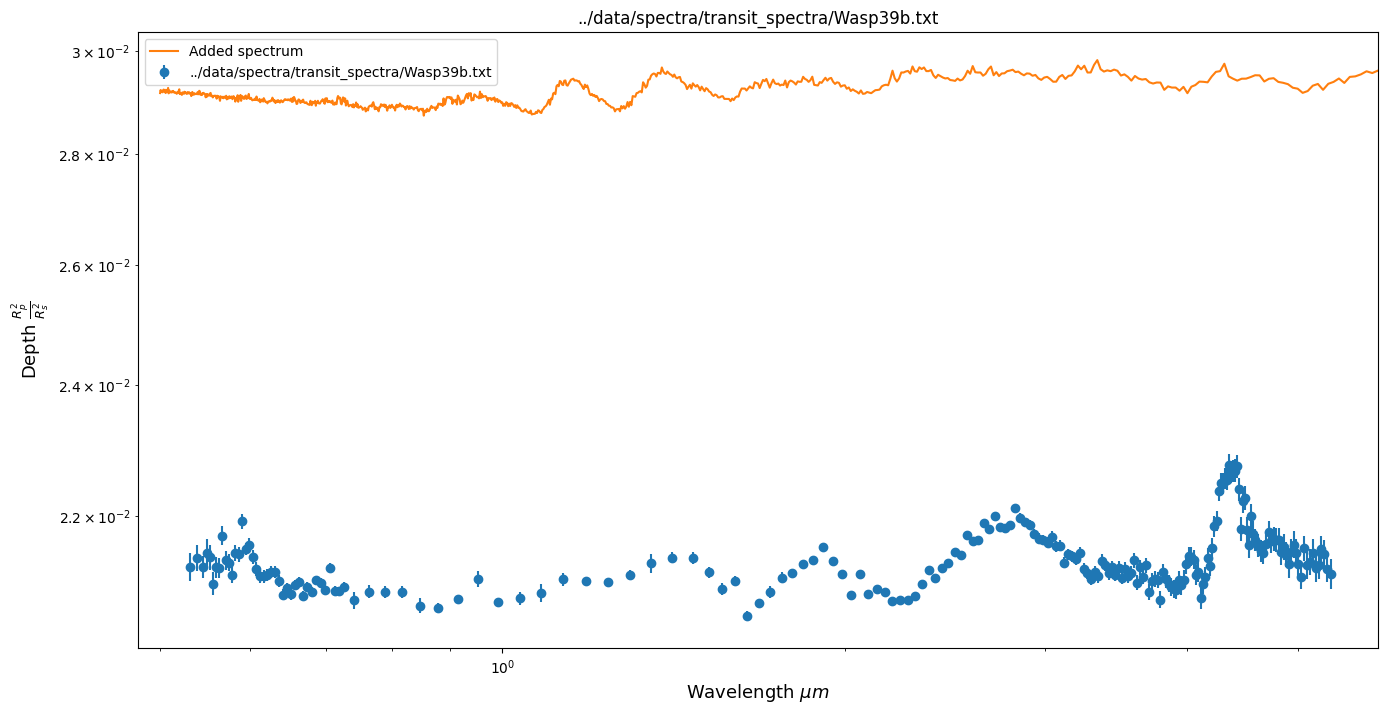

In [16]:
T_irr = T_irr_at_planet(0.90,5400,0.0486)
planet = np.array([0.28,T_irr,1.1,10,500,3.76,1*10**(8.22)]).reshape(1,-1)
model_depth = ML.use_model(ML_depth,planet).reshape(-1,1)[:-1]
radius = ML.use_model(ML_depth,planet).reshape(-1,1)[-1]
model_depth = model_depth*radius**2/(0.9*R_s)**2

IT.plot_transit(added_spectrum=(ML.wavelength,model_depth))

To find the most likely set of parameters that, given the HADES model, best fits the observations, we must run a Bayesian sampling algorithm to explore the planetary properties and sample the posterior distribution.  

Within the HADES framework, there is a Monte Carlo Markov Chain (MCMC) setup using the ML model. To use this, we need the following:  

- Define the initial positions of the walkers (never use 0) and the bounds.  
- Define the parameter space to explore (bounds).  
- Estimate the irradiation temperature of the planet using the *T_irr_at_planet* function. The arguments are: stellar radius (in meters), stellar temperature (in Kelvin), and semi-major axis (in AU).  
- Set up the MCMC by defining the number of steps and walkers to use.  

loaded example wavelength


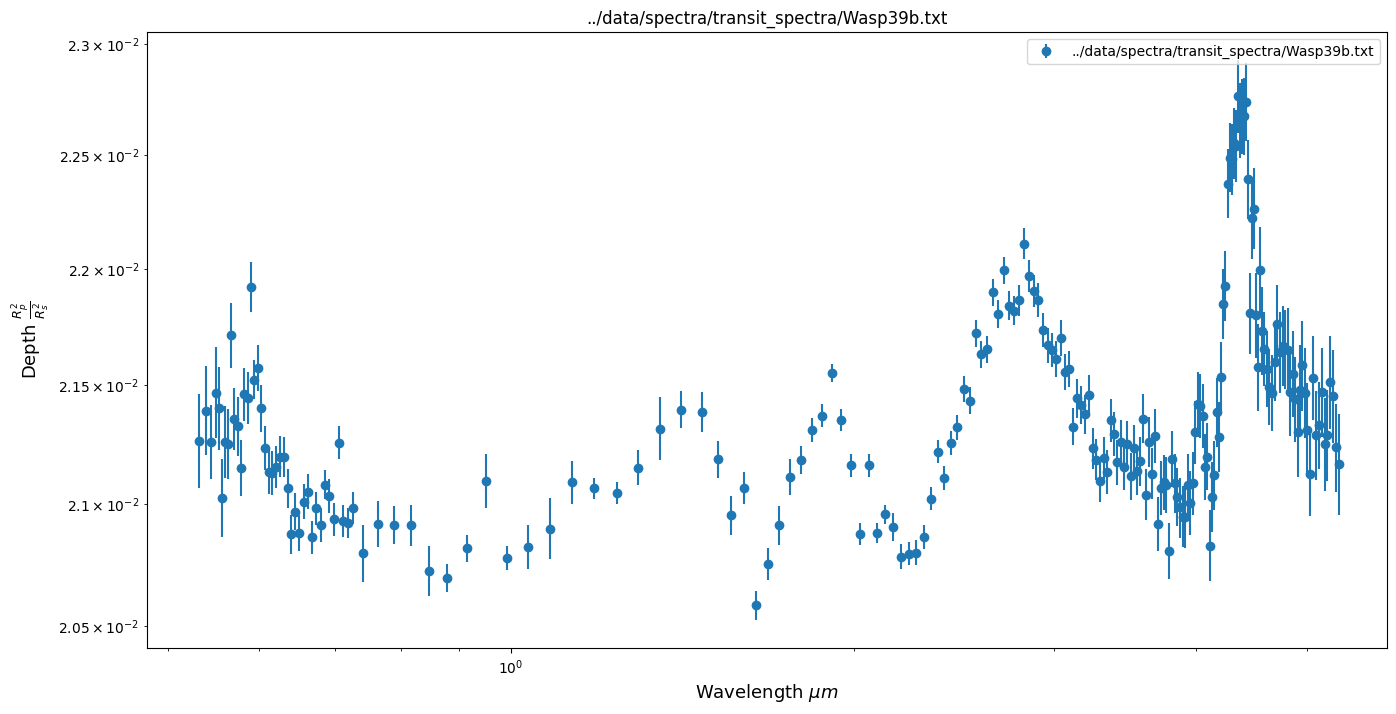

<class 'pandas.core.frame.DataFrame'>
Initializing Entropy
loaded example wavelength
Loading model
Loading ../data/interpolators/nonlinear//depth_radius.pkl
Loaded ../data/interpolators/nonlinear//depth_radius.pkl
Loaded model
Initializing Entropy
Initializing positions
Parameter 0 : 0.5157050263426817
Parameter 1 : 1.1157858424742328
Parameter 2 : 19.493994433747535
Parameter 3 : 348.8945783697774
Parameter 4 : 3.2017185491535853
Parameter 5 : 10207187.722566158
Parameter 0 : 0.5950605127722957
Parameter 1 : 1.0033569322828273
Parameter 2 : 17.374704291192955
Parameter 3 : 485.5293093272833
Parameter 4 : 2.7256477422535834
Parameter 5 : 9225104.79898532
Parameter 0 : 0.6045369673413834
Parameter 1 : 0.9389749122722173
Parameter 2 : 18.559671858111447
Parameter 3 : 396.1553357084084
Parameter 4 : 2.752430004445743
Parameter 5 : 9145270.344805192
Parameter 0 : 0.4528918507804399
Parameter 1 : 1.002796583420593
Parameter 2 : 22.14191416723619
Parameter 3 : 384.6806189525282
Parameter 4 :

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


In [ ]:
initial_parameters = [
        0.28,
        1,
        20,
        400,
        3,
        1e7]
bounds = (
        [0.05,10],
        [-1,1.3],
        [0,100],
        [0,1000],
        [1,6],
        [1e4,1e10])

planet_mass = [0.28, 0.03] # set to [0,0] for no mass constraint
T_irr = T_irr_at_planet(0.9,5400.0,0.0486)
n_walkers = 48
n_iterations = 3000
observed_spectrum = IT.observed_spectrum
spectrum_name = 'wasp39b'
arguments = ''
output_file = '../data/retrievals/planets'
distance_planet = 230.0
planet_age = 0
planet_age_error = 0
reset = True

RetrieveTransit_MCMC(
    initial_parameters,
    T_irr,
    planet_mass,
    bounds,
    n_walkers,
    n_iterations,
    observed_spectrum,
    spectrum_name,
    output_file,
    distance_planet,
    planet_age,
    planet_age_error,
    reset,
    arguments=arguments,
    debug=False).MCMC()

The various plots of interest following the MCMC analysis can be generated using the *PlotTransitRetrieval* class:  
- **plot_chains**: Plots the chains across the parameter space. This helps assess whether the MCMC has converged and determine the burn-in phase to remove (controlled by the *shorten* parameter).  
- **plot_transit_fit**: Plots the observed spectrum alongside the model spectrum (obtained via regression within the grid for each sample).  
- **corner_plot**: Generates a corner plot to visualize the posterior distributions.  


In [2]:
PT = PlotTransitRetreival(
    analysed_planet='wasp39b',shorten=0,
    retrieval_info='')

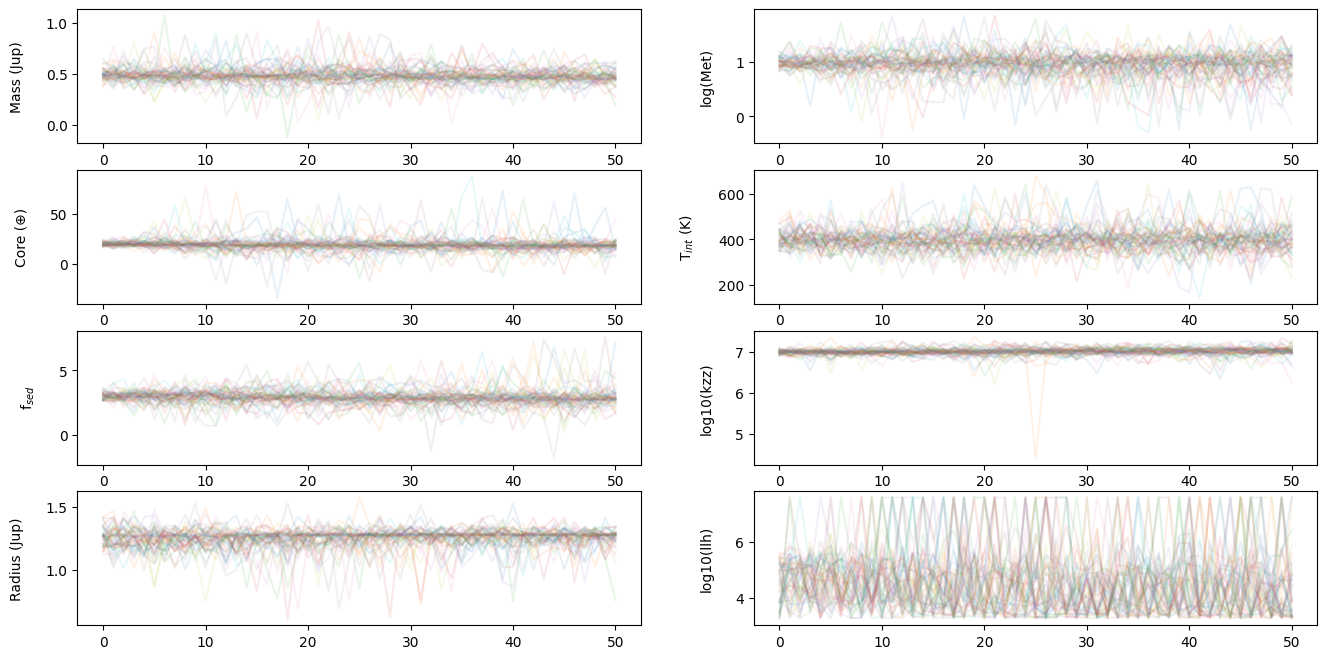

In [3]:
PT.plot_chains()

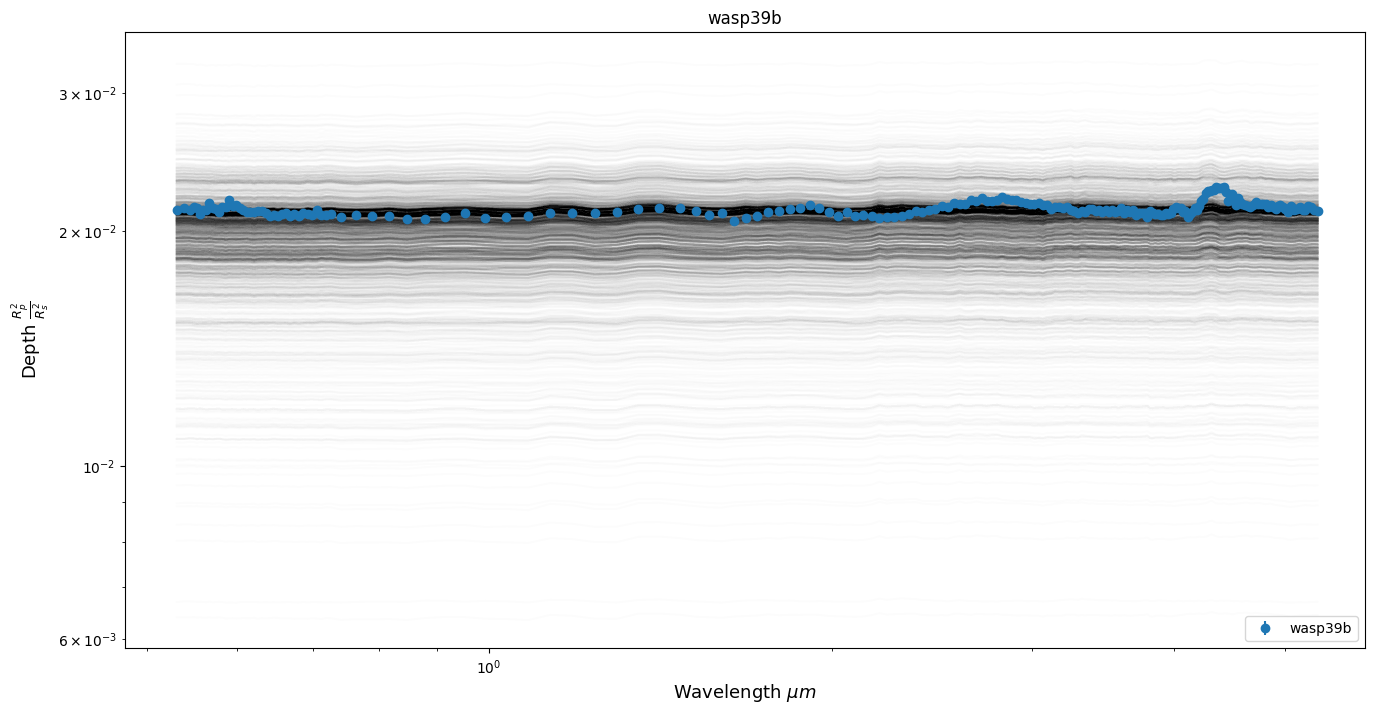

In [5]:
PT.plot_transit_fit(type='sigma')

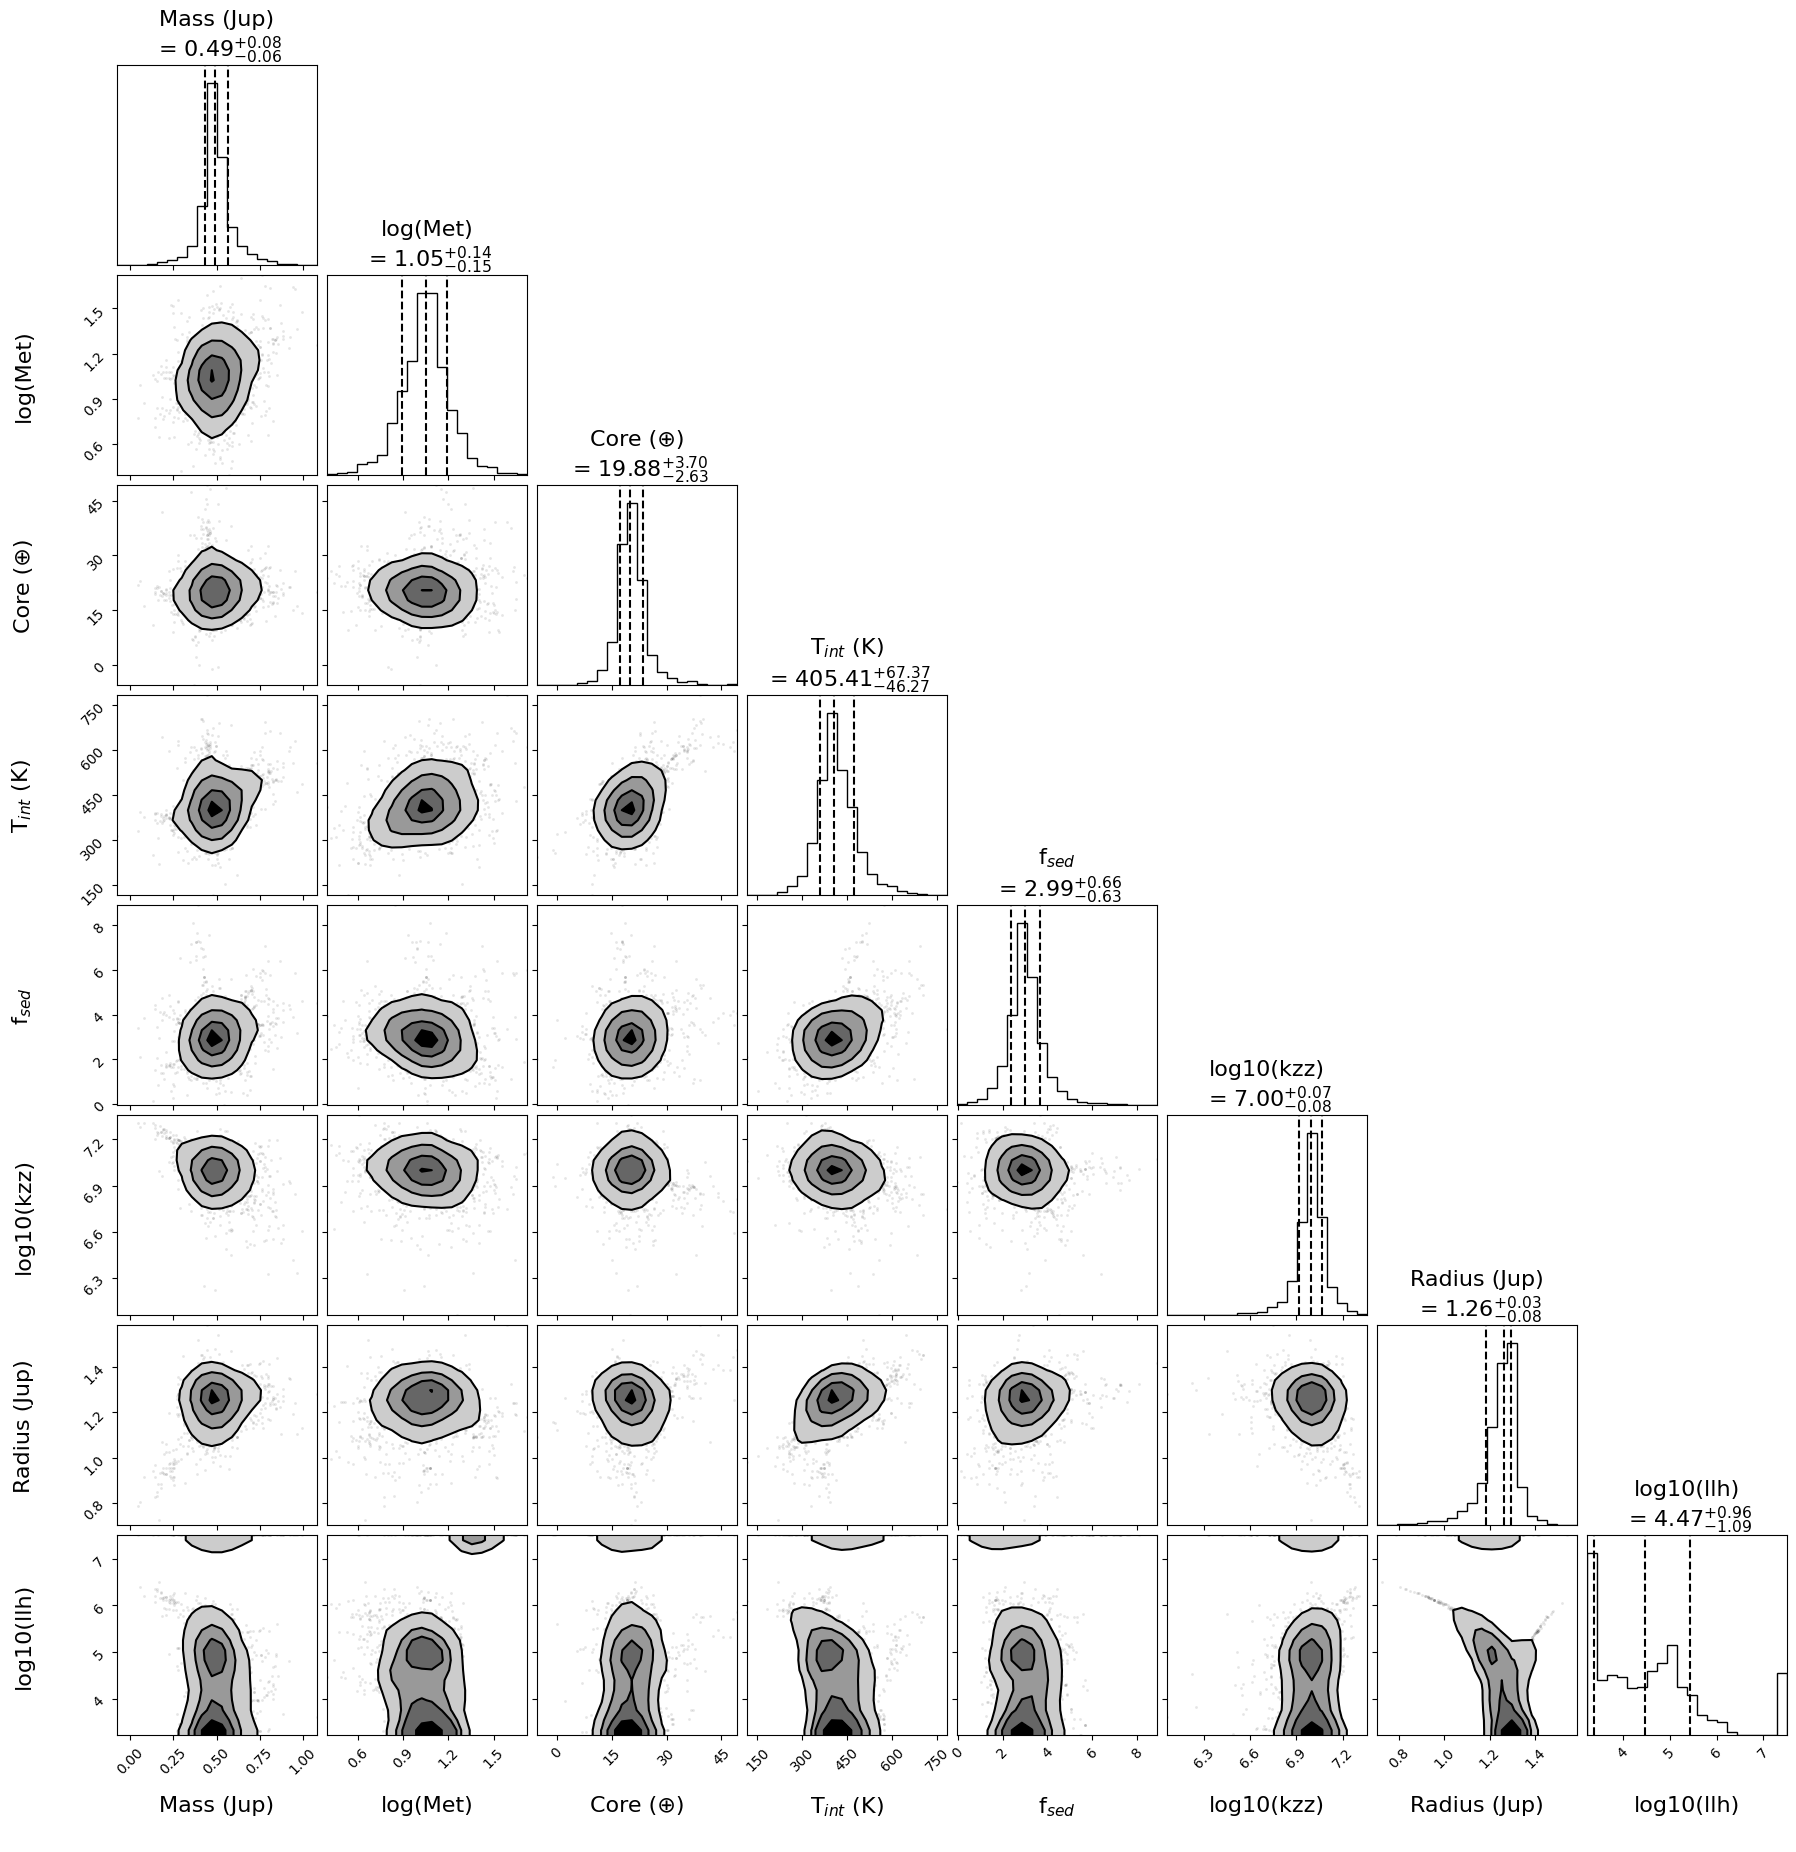

Corner plot made


In [8]:
PT.corner_plot()

loaded example wavelength


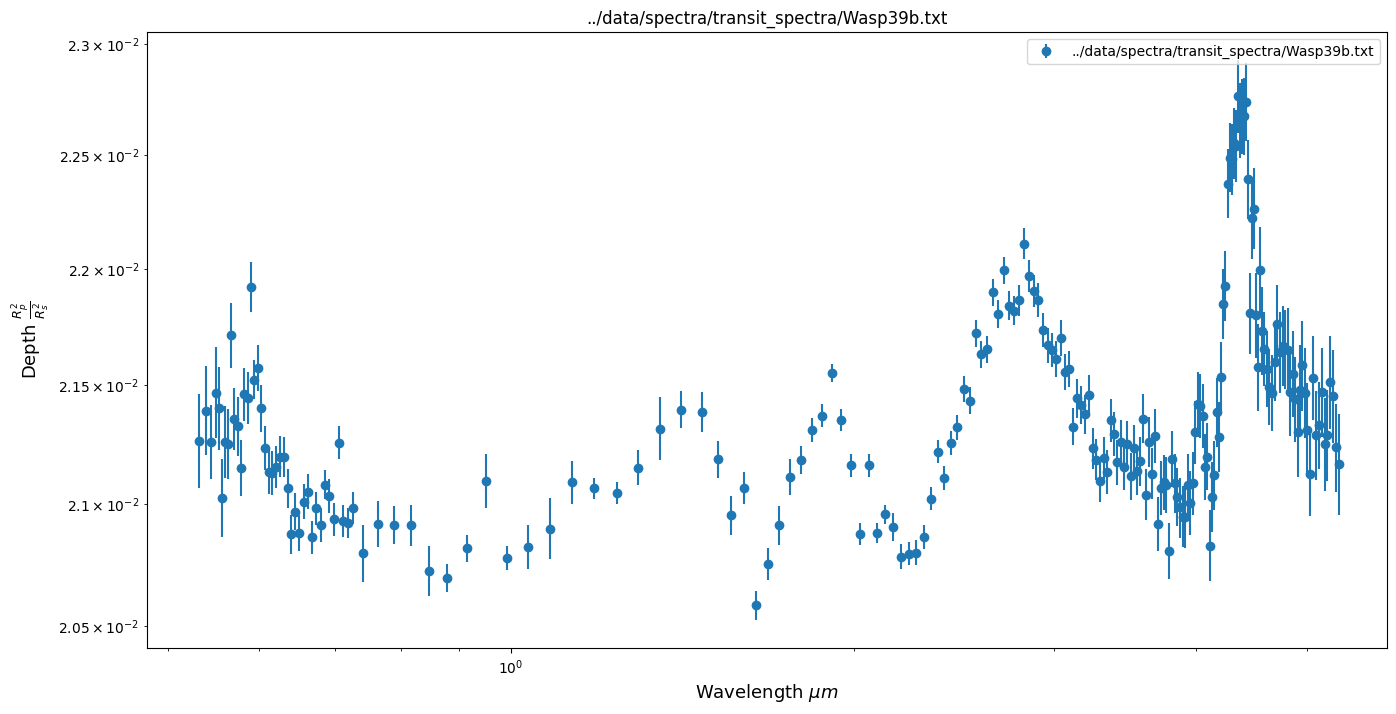

<class 'pandas.core.frame.DataFrame'>
Initializing Entropy
loaded example wavelength
Loading model
Loading ../data/interpolators/nonlinear//depth_radius.pkl
Loaded ../data/interpolators/nonlinear//depth_radius.pkl
Loaded model
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+03  .-1665.88 [-473409.7851..-268942.7191] | it/evals=998/2534 eff=46.4386% N=393  0 
[ultranest] Likelihood function evaluations: 2534
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -1692 +- 29.13
[ultranest] Effective samples strategy satisfied (ESS = 1.0, need >400)
[ultranest] Posterior uncertainty strategy wants to improve: -3661767.00..-1665.88 (KL: 17.79+-85.17 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 391 minimum live points (dlogz from 17.98 to 102.50, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:29.13 tail:0.69 total:29.13 required:<0.50
[ultranest] Widening from 1 to 800 live points before L=-4e+06...
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 800 live points (have 400 already) ...
[ultranest] Sampling 400 live points from prior ...
[ultranest] Exploring (in particular: L=-inf..-16

In [ ]:
initial_parameters = [
        0.5,
        1,
        20,
        400,
        3,
        1e7]

bounds = (
        [0.05,10],
        [-1,1.3],
        [0,100],
        [0,1000],
        [1,6],
        [1e4,1e10])

planet_mass = [0.28, 0.03] # set to [0,0] for no mass constraint
T_irr = T_irr_at_planet(0.9,5400.0,0.0486)
observed_spectrum = IT.observed_spectrum
spectrum_name = 'wasp39b'
output_file = '../data/retrievals/planets'
distance_planet = 230.0
planet_age = 0
planet_age_error = 0

RT = RetrieveTransit_UltraNest(
    T_irr,
    planet_mass,
    bounds,
    observed_spectrum,
    spectrum_name,
    output_file,
    distance_planet,
    planet_age,
    planet_age_error)

results = RT.ultranest(n_iterations_max=1000, resume="overwrite")

In [2]:
RT.ultranest_sampler.print_results()
RT.ultranest_sampler.plot()
RT.ultranest_sampler.plot_corner()


logZ = -1674.597 +- 0.908
  single instance: logZ = -1674.597 +- 0.131
  bootstrapped   : logZ = -1694.030 +- 0.587
  tail           : logZ = +- 0.693
insert order U test : converged: True correlation: inf iterations

    $M_{tot}$           : 0.05000995000000000│              ▇                        │0.93250077031751810    0.38250077031751806 +- 0.00000000000000011
    Met                 : -0.406│                   ▇                   │0.694     0.144 +- 0.000
    $M_c$               : 35.606│                   ▇                   │36.706    36.156 +- 0.000
    $T_{int}$           : 983.60294519726665│                   ▇                   │984.70294519726656    984.15294519726649 +- 0.00000000000011
    $f_{sed}$           : 5.250 │                            ▇          │6.000     5.800 +- 0.000
    $k_{zz}$            : 2007859370.82549882│                   ▇                   │2007859371.92549920    2007859371.37549949 +- 0.00000048

[ultranest] Posterior is still concentrated 